# MOVIELENS大作业

数据导入及数据集展示

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# Reading ratings file
ratings = pd.read_csv('./ratings2.csv',  encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('./users.csv', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('./movies.csv',  encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

# Reading movies info file
movies_info = pd.read_csv('./info.csv',  encoding='latin-1', usecols=['id', 'name', 'genre','intro','directors','starts', 'release_time'])
movies_info.rename(columns ={ 'id':'movie_id', 'starts': 'stars','genre':'genres'}, inplace = True)

In [2]:
ratings.head(n=3)

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968


In [3]:
users.head(n=3)

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist


In [4]:
movies.head(n=3)

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [5]:
movies_info.head(n=3)

,movie_id,name,genres,release_time,intro,directors,stars
0,1,Toy Story (1995),Animation|Adventure|Comedy,22 November 1995 (USA),A cowboy doll is profoundly threatened and jea...,John Lasseter,Tom Hanks|Tim Allen|Don Rickles
1,2,Jumanji (1995),Adventure|Comedy|Family,15 December 1995 (USA),When two kids find and play a magical board ga...,Joe Johnston,Robin Williams|Kirsten Dunst|Bonnie Hunt
2,3,Grumpier Old Men (1995),Comedy|Romance,22 December 1995 (USA),John and Max resolve to save their beloved bai...,Howard Deutch,Walter Matthau|Jack Lemmon|Ann-Margret


#### 一、传统偏好发现(30分)

主题选定：年龄偏好分析

1.（20分）合理的衡量偏好程度的指标（2~3个），言之成理即可（可以仿照男女偏好程度）（10分），并根据指标衡量并筛选出不同类型用户的前10个电影并进行展示（10分）<br>


In [6]:
# 筛选出观影人次大于300的电影
popular = ratings['movie_id'].value_counts()
popular = popular[popular > 300]
popular = popular.rename('count')
popular = popular.rename_axis('movie_id')
print("Popular:")
display(popular.head(n=3))

Popular:


movie_id
2858    3428
260     2991
1196    2990
Name: count, dtype: int64

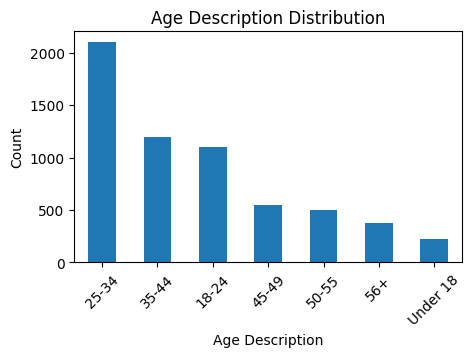

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3))
users['age_desc'].value_counts().plot(kind='bar')
plt.title('Age Description Distribution')
plt.xlabel('Age Description')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

我们选择将人群重新归类为少年组（0-25岁）、青年组（25-45岁）和中老年组（45+岁），由于我们不认为偏好一定随着年龄呈现正/负相关（即，某种偏好少年组>青年组不能推导出青年组>中老年组），我们设立三个指标，分别为少年组比其他组别更偏好程度、青年组比其他组别更偏好程度、中老年组比其他组别更偏好程度，其度量方法分别为：<br>
youth_score=(youth_avr_rate-other_avr_rate)*ln(观影人数)<br>
adult_score=(adult_avr_rate-other_avr_rate)*ln(观影人数)<br>
old_score=(old_avr_rate-other_avr_rate)*ln(观影人数)<br>

In [8]:
age_users = pd.merge(users, ratings, on='user_id', how='outer')
age_users = age_users[age_users['movie_id'].isin(popular.index)] 
youth_users = age_users[(age_users['age_desc'] == 'Under 18' )|( age_users['age_desc'] == '18-24')]
adult_users = age_users[(age_users['age_desc'] == '25-34')| (age_users['age_desc'] == '35-44')]
old_users= age_users[(age_users['age_desc'] == '45-49')| (age_users['age_desc'] == '50-55')| (age_users['age_desc'] == '56+')]
other_youth = pd.concat([age_users, youth_users]).drop_duplicates(keep=False)
other_adult = pd.concat([age_users, adult_users]).drop_duplicates(keep=False)
other_old = pd.concat([age_users, old_users]).drop_duplicates(keep=False)

In [9]:
# 计算平均打分
youth_mean_rating = youth_users.groupby('movie_id')['rating'].mean()
adult_mean_rating = adult_users.groupby('movie_id')['rating'].mean()
old_mean_rating= old_users.groupby('movie_id')['rating'].mean()
other_youth_mean_rating = other_youth.groupby('movie_id')['rating'].mean()
other_adult_mean_rating = other_adult.groupby('movie_id')['rating'].mean()
other_old_mean_rating = other_old.groupby('movie_id')['rating'].mean()
print("Youth mean rating:")
display(youth_mean_rating.head(n=3))
print("Adult mean rating:")
display(adult_mean_rating.head(n=3))
print("Old mean rating:")
display(old_mean_rating.head(n=3))


Youth mean rating:


movie_id
1    3.998214
2    3.068421
3    3.144000
Name: rating, dtype: float64

Adult mean rating:


movie_id
1    4.236603
2    3.202970
3    2.968872
Name: rating, dtype: float64

Old mean rating:


movie_id
1    4.062500
2    3.429907
3    2.979167
Name: rating, dtype: float64

In [10]:
# 计算评价函数
youth_score = youth_mean_rating - other_youth_mean_rating
youth_score = pd.merge(youth_score, popular, on='movie_id', how='outer') 
youth_score['youth_score'] = youth_score['rating'] * np.log(youth_score['count']) 
print("\nYouth Score:")
display(youth_score)
adult_score = adult_mean_rating - other_adult_mean_rating
adult_score = pd.merge(adult_score, popular, on='movie_id', how='outer') 
adult_score['adult_score'] = adult_score['rating'] * np.log(adult_score['count']) 
print("\nAdult Score:")
display(adult_score)
old_score = old_mean_rating - other_old_mean_rating
old_score = pd.merge(old_score, popular, on='movie_id', how='outer') 
old_score['old_score'] = old_score['rating'] * np.log(old_score['count']) 
print("\nOld Score:")
display(old_score)


Youth Score:


,rating,count,youth_score
movie_id,,,
1,-0.203500,2077,-1.554468
2,-0.182068,701,-1.193003
3,0.172329,478,1.063200
6,0.185583,940,1.270481
7,0.096744,458,0.592741
...,...,...,...
3916,-0.194585,437,-1.183062
3927,-0.143434,348,-0.839407
3948,0.233427,862,1.577793



Adult Score:


,rating,count,adult_score
movie_id,,,
1,0.215770,2077,1.648199
2,0.004317,701,0.028288
3,-0.103527,478,-0.638719
6,-0.024105,940,-0.165017
7,-0.093845,458,-0.574973
...,...,...,...
3916,0.119015,437,0.723601
3927,0.178630,348,1.045376
3948,-0.028916,862,-0.195449



Old Score:


,rating,count,old_score
movie_id,,,
1,-0.098809,2077,-0.754767
2,0.269974,701,1.769006
3,-0.047011,478,-0.290042
6,-0.259764,940,-1.778316
7,0.045710,458,0.280057
...,...,...,...
3916,0.054348,437,0.330431
3927,-0.154392,348,-0.903533
3948,-0.288967,862,-1.953203


In [11]:
# 选出前10个不同类型用户喜欢的电影
youth_preference = youth_score.nlargest(10, 'youth_score').reset_index()
adult_preference = adult_score.nlargest(10, 'adult_score').reset_index()
old_preference = old_score.nlargest(10, 'old_score').reset_index()
# 详细展示这些选出的电影的信息
print("少年组最偏好的10部电影：")
youth_preference_detail = pd.merge(youth_preference, movies, on='movie_id', how='inner')
youth_preference_detail = youth_preference_detail.drop(['rating', 'count', 'youth_score', 'movie_id'], axis=1) 
youth_preference_detail['ranking'] = youth_preference_detail.index.to_series().apply(lambda x: x+1)
youth_preference_detail = youth_preference_detail.set_index('ranking') 
display(youth_preference_detail)

print("青年组最偏好的10部电影：")
adult_preference_detail = pd.merge(adult_preference, movies, on='movie_id', how='inner')
adult_preference_detail = adult_preference_detail.drop(['rating', 'count', 'adult_score', 'movie_id'], axis=1) 
adult_preference_detail['ranking'] = adult_preference_detail.index.to_series().apply(lambda x: x+1)
adult_preference_detail = adult_preference_detail.set_index('ranking') 
display(adult_preference_detail)

print("中老年组最偏好的10部电影：")
old_preference_detail = pd.merge(old_preference, movies, on='movie_id', how='inner')
old_preference_detail = old_preference_detail.drop(['rating', 'count', 'old_score', 'movie_id'], axis=1) 
old_preference_detail['ranking'] = old_preference_detail.index.to_series().apply(lambda x: x+1)
old_preference_detail = old_preference_detail.set_index('ranking') 
display(old_preference_detail)


少年组最偏好的10部电影：


,title,genres
ranking,,
1,Spaceballs (1987),Comedy|Sci-Fi
2,Clue (1985),Comedy|Mystery
3,"Goonies, The (1985)",Adventure|Children's|Fantasy
4,Billy Madison (1995),Comedy
5,Three Amigos! (1986),Comedy|Western
6,Robin Hood: Men in Tights (1993),Comedy
7,Rocky IV (1985),Action|Drama
8,Gremlins 2: The New Batch (1990),Comedy|Horror
9,European Vacation (1985),Comedy


青年组最偏好的10部电影：


,title,genres
ranking,,
1,Godzilla (Gojira) (1954),Action|Sci-Fi
2,"Brady Bunch Movie, The (1995)",Comedy
3,Beneath the Planet of the Apes (1970),Action|Sci-Fi
4,Highlander (1986),Action|Adventure
5,Kelly's Heroes (1970),Action|Comedy|War
6,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller
7,"Jungle Book, The (1967)",Animation|Children's|Comedy|Musical
8,"American Werewolf in London, An (1981)",Horror
9,True Grit (1969),Adventure|Western


中老年组最偏好的10部电影：


,title,genres
ranking,,
1,Star Trek V: The Final Frontier (1989),Action|Adventure|Sci-Fi
2,Desperately Seeking Susan (1985),Comedy|Romance
3,Mission to Mars (2000),Sci-Fi
4,Batman & Robin (1997),Action|Adventure|Crime
5,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller
6,Sister Act (1992),Comedy|Crime
7,Pocahontas (1995),Animation|Children's|Musical|Romance
8,Sleepless in Seattle (1993),Comedy|Romance
9,Dirty Dancing (1987),Musical|Romance


In [12]:
#模仿demo给出其他流行统计量后的推荐偏好
R=ratings.groupby('movie_id')['rating'].mean()
N=ratings.groupby('movie_id')['rating'].count()
popular=pd.DataFrame({'rating':R,'count':N})
W=popular['count'].apply(lambda x: max(0.5*x/popular['count'].mean(),1))
popular['rating']=W*popular['rating']+(1-W)*popular['rating'].mean()
popular=popular.sort_values(by='rating',ascending=False)
popular_percentile=popular['rating'].quantile(0.9)
popular=popular[popular['rating']>=popular_percentile]
print(popular)
age_users = pd.merge(users, ratings, on='user_id', how='outer')
age_users = age_users[age_users['movie_id'].isin(popular.index)] 
youth_users = age_users[(age_users['age_desc'] == 'Under 18' )|( age_users['age_desc'] == '18-24')]
adult_users = age_users[(age_users['age_desc'] == '25-34')| (age_users['age_desc'] == '35-44')]
old_users= age_users[(age_users['age_desc'] == '45-49')| (age_users['age_desc'] == '50-55')| (age_users['age_desc'] == '56+')]
other_youth = pd.concat([age_users, youth_users]).drop_duplicates(keep=False)
other_adult = pd.concat([age_users, adult_users]).drop_duplicates(keep=False)
other_old = pd.concat([age_users, old_users]).drop_duplicates(keep=False)
# 计算平均打分
youth_mean_rating = youth_users.groupby('movie_id')['rating'].mean()
adult_mean_rating = adult_users.groupby('movie_id')['rating'].mean()
old_mean_rating= old_users.groupby('movie_id')['rating'].mean()
other_youth_mean_rating = other_youth.groupby('movie_id')['rating'].mean()
other_adult_mean_rating = other_adult.groupby('movie_id')['rating'].mean()
other_old_mean_rating = other_old.groupby('movie_id')['rating'].mean()
print("Youth mean rating:")
display(youth_mean_rating)
print("\nAdult mean rating:")
display(adult_mean_rating)
print("\nOld mean rating:")
display(old_mean_rating)
# 计算评价函数
youth_score = youth_mean_rating - other_youth_mean_rating
youth_score = pd.merge(youth_score, popular, on='movie_id', how='outer') 
youth_score['youth_score'] = youth_score['rating_x'] * youth_score['rating_y']
print("\nYouth Score:")
display(youth_score)
adult_score = adult_mean_rating - other_adult_mean_rating
adult_score = pd.merge(adult_score, popular, on='movie_id', how='outer') 
adult_score['adult_score'] = adult_score['rating_x'] * adult_score['rating_y']
print("\nAdult Score:")
display(adult_score)
old_score = old_mean_rating - other_old_mean_rating
old_score = pd.merge(old_score, popular, on='movie_id', how='outer') 
old_score['old_score'] = old_score['rating_x'] * old_score['rating_y']
print("\nOld Score:")
display(old_score)
# 选出前10个不同类型用户喜欢的电影
youth_preference = youth_score.nlargest(10, 'youth_score').reset_index()
adult_preference = adult_score.nlargest(10, 'adult_score').reset_index()
old_preference = old_score.nlargest(10, 'old_score').reset_index()
# 详细展示这些选出的电影的信息
print("少年组最偏好的10部电影：")
youth_preference_detail = pd.merge(youth_preference, movies, on='movie_id', how='inner')
youth_preference_detail = youth_preference_detail.drop(['rating_x', 'rating_y', 'youth_score', 'movie_id'], axis=1) 
youth_preference_detail['ranking'] = youth_preference_detail.index.to_series().apply(lambda x: x+1)
youth_preference_detail = youth_preference_detail.set_index('ranking') 
display(youth_preference_detail)
print("青年组最偏好的10部电影：")
adult_preference_detail = pd.merge(adult_preference, movies, on='movie_id', how='inner')
adult_preference_detail = adult_preference_detail.drop(['rating_x', 'rating_y', 'adult_score', 'movie_id'], axis=1) 
adult_preference_detail['ranking'] = adult_preference_detail.index.to_series().apply(lambda x: x+1)
adult_preference_detail = adult_preference_detail.set_index('ranking') 
display(adult_preference_detail)
print("中老年组最偏好的10部电影：")
old_preference_detail = pd.merge(old_preference, movies, on='movie_id', how='inner')
old_preference_detail = old_preference_detail.drop(['rating_x', 'rating_y', 'old_score', 'movie_id'], axis=1) 
old_preference_detail['ranking'] = old_preference_detail.index.to_series().apply(lambda x: x+1)
old_preference_detail = old_preference_detail.set_index('ranking') 
display(old_preference_detail)


             rating  count
movie_id                  
2858      10.088146   3428
260        9.970312   2991
1196       9.077795   2990
1198       9.008716   2514
318        8.667024   2227
...             ...    ...
1280       4.173285    277
955        4.169492    413
2726       4.169231    130
2948       4.168559    771
3424       4.167839    781

[371 rows x 2 columns]
Youth mean rating:


movie_id
1       3.998214
6       4.016529
11      3.671569
17      3.954887
21      3.609244
          ...   
3793    3.917695
3801    4.384615
3881    5.000000
3897    4.295203
3911    3.969466
Name: rating, Length: 354, dtype: float64


Adult mean rating:


movie_id
1       4.236603
6       3.869338
11      3.774300
17      4.006263
21      3.586605
          ...   
3793    3.825740
3801    4.078947
3888    5.000000
3897    4.172101
3911    4.040921
Name: rating, Length: 361, dtype: float64


Old mean rating:


movie_id
1       4.062500
6       3.653226
11      3.959459
17      4.116592
21      3.765873
          ...   
3793    3.469388
3801    4.318182
3888    4.000000
3897    4.292398
3911    4.266667
Name: rating, Length: 361, dtype: float64


Youth Score:


,rating_x,rating_y,count,youth_score
movie_id,,,,
1,-0.203500,6.732588,2077,-1.370079
6,0.185583,4.353130,940,0.807869
11,-0.152316,4.300855,1033,-0.655087
17,-0.086423,4.458884,835,-0.385352
21,-0.017769,4.206071,1356,-0.074737
...,...,...,...,...
3801,0.164185,4.231156,199,0.694693
3881,NaN,5.000000,1,NaN
3888,NaN,4.500000,2,NaN



Adult Score:


,rating_x,rating_y,count,adult_score
movie_id,,,,
1,0.215770,6.732588,2077,1.452691
6,-0.024105,4.353130,940,-0.104931
11,-0.047296,4.300855,1033,-0.203415
17,-0.049917,4.458884,835,-0.222573
21,-0.103191,4.206071,1356,-0.434028
...,...,...,...,...
3801,-0.246256,4.231156,199,-1.041947
3881,NaN,5.000000,1,NaN
3888,1.000000,4.500000,2,4.500000



Old Score:


,rating_x,rating_y,count,old_score
movie_id,,,,
1,-0.098809,6.732588,2077,-0.665237
6,-0.259764,4.353130,940,-1.130788
11,0.211001,4.300855,1033,0.907484
17,0.121494,4.458884,835,0.541727
21,0.174388,4.206071,1356,0.733486
...,...,...,...,...
3801,0.194586,4.231156,199,0.823325
3881,NaN,5.000000,1,NaN
3888,-1.000000,4.500000,2,-4.500000


少年组最偏好的10部电影：


,count,title,genres
ranking,,,
1,2,Dangerous Game (1993),Drama
2,74,"Face in the Crowd, A (1957)",Drama
3,104,"Palm Beach Story, The (1942)",Comedy
4,3428,American Beauty (1999),Comedy|Drama
5,47,Pather Panchali (1955),Drama
6,69,Sanjuro (1962),Action|Adventure
7,5,NÃ©nette et Boni (1996),Drama
8,90,Trust (1990),Comedy|Drama
9,28,Before the Rain (Pred dozhdot) (1994),Drama


青年组最偏好的10部电影：


,count,title,genres
ranking,,,
1,2,"Inheritors, The (Die Siebtelbauern) (1998)",Drama
2,2,Skipped Parts (2000),Drama|Romance
3,8,Window to Paris (1994),Comedy
4,10,Time of the Gypsies (Dom za vesanje) (1989),Drama
5,62,"Decline of Western Civilization, The (1981)",Documentary
6,5,Return with Honor (1998),Documentary
7,27,For All Mankind (1989),Documentary
8,12,"Eighth Day, The (Le HuitiÃ¨me jour ) (1996)",Drama
9,2514,Raiders of the Lost Ark (1981),Action|Adventure


中老年组最偏好的10部电影：


,count,title,genres
ranking,,,
1,2,"Bells, The (1926)",Crime|Drama
2,28,Before the Rain (Pred dozhdot) (1994),Drama
3,8,Ed's Next Move (1996),Comedy
4,5,Return with Honor (1998),Documentary
5,12,Jupiter's Wife (1994),Documentary
6,23,Aparajito (1956),Drama
7,57,"Conformist, The (Il Conformista) (1970)",Drama
8,1057,"African Queen, The (1951)",Action|Adventure|Romance|War
9,986,Sleepless in Seattle (1993),Comedy|Romance


2.（10分）基于电影风格的可视化（一个图3.5分）：
不同类型用户对不同类型电影的评分的可视化，不同类型用户对不同类型电影的观看数量的可视化...


In [13]:
data = pd.merge(ratings, users, how='outer')
data = pd.merge(data, movies, how='outer')
data

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres
0,1.0,1193,5.0,978300760.0,F,48067,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama
1,2.0,1193,5.0,978298413.0,M,70072,56+,self-employed,One Flew Over the Cuckoo's Nest (1975),Drama
2,12.0,1193,4.0,978220179.0,M,32793,25-34,programmer,One Flew Over the Cuckoo's Nest (1975),Drama
3,15.0,1193,4.0,978199279.0,M,22903,25-34,executive/managerial,One Flew Over the Cuckoo's Nest (1975),Drama
4,17.0,1193,5.0,978158471.0,M,95350,50-55,academic/educator,One Flew Over the Cuckoo's Nest (1975),Drama
...,...,...,...,...,...,...,...,...,...,...
1000381,NaN,3650,NaN,NaN,NaN,NaN,NaN,NaN,Anguish (Angustia) (1986),Horror
1000382,NaN,3750,NaN,NaN,NaN,NaN,NaN,NaN,Boricua's Bond (2000),Drama
1000383,NaN,3829,NaN,NaN,NaN,NaN,NaN,NaN,Mad About Mambo (2000),Comedy|Romance
1000384,NaN,3856,NaN,NaN,NaN,NaN,NaN,NaN,Autumn Heart (1999),Drama


In [14]:
data_youth = data[(data.age_desc=='18-24') | (data.age_desc=='Under 18')]
data_adult = data[(data.age_desc=='25-34') | (data.age_desc=='35-44')]
data_old = data[(data.age_desc=='45-49') | (data.age_desc=='50-55') | (data.age_desc=='56+')]
youth_count= data_youth.shape[0]
adult_count = data_adult.shape[0]
old_count = data_old.shape[0]
data_youth.shape, data_adult.shape, data_old.shape

((210747, 10), (594559, 10), (194903, 10))

In [15]:
genre_list = []
for i in movies.genres:
    genre = i.split(sep='|')
    genre_list += genre
genre_list = list(set(genre_list))
genre_list

["Children's",
 'Action',
 'Animation',
 'Comedy',
 'Drama',
 'Musical',
 'Western',
 'Sci-Fi',
 'Documentary',
 'Fantasy',
 'Mystery',
 'Thriller',
 'Horror',
 'Adventure',
 'Romance',
 'Film-Noir',
 'Crime',
 'War']

In [16]:
num_movies = movies.shape[0]
for genre in genre_list:
    movies[genre] = 0
for i in movies.index:
    genre = movies.loc[i].genres.split(sep='|')
    for j in genre:
        movies[j][i] = 1
movies

,movie_id,title,genres,Children's,Action,Animation,Comedy,Drama,Musical,Western,...,Documentary,Fantasy,Mystery,Thriller,Horror,Adventure,Romance,Film-Noir,Crime,War
0,1,Toy Story (1995),Animation|Children's|Comedy,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3878,3948,Meet the Parents (2000),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3879,3949,Requiem for a Dream (2000),Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3880,3950,Tigerland (2000),Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3881,3951,Two Family House (2000),Drama,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data_2 = pd.merge(ratings, users, how='outer')
data_2 = pd.merge(data, movies, how='outer')
data_2.shape

(1000386, 28)

In [18]:
data_2_youth = data_2[(data_2.age_desc=='18-24') | (data_2.age_desc=='Under 18')]
data_2_adult = data_2[(data_2.age_desc=='25-34') | (data_2.age_desc=='35-44')]
data_2_old = data_2[(data_2.age_desc=='45-49') | (data_2.age_desc=='50-55') | (data_2.age_desc=='56+')]
data_2_youth.head()

,user_id,movie_id,rating,timestamp,gender,zipcode,age_desc,occ_desc,title,genres,...,Documentary,Fantasy,Mystery,Thriller,Horror,Adventure,Romance,Film-Noir,Crime,War
0,1.0,1193,5.0,978300760.0,F,48067,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
5,18.0,1193,4.0,978156168.0,F,95825,18-24,clerical/admin,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
6,19.0,1193,5.0,982730936.0,M,48073,Under 18,K-12 student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
10,39.0,1193,5.0,978043535.0,M,61820,18-24,college/grad student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0
13,47.0,1193,4.0,977978345.0,M,94305,18-24,college/grad student,One Flew Over the Cuckoo's Nest (1975),Drama,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# 初始化一个用于对比男女不同风格差异的表格
df_2 = pd.DataFrame(np.zeros((len(genre_list), 18)), index=genre_list, 
                    columns=pd.MultiIndex.from_tuples([('Youth', 'mean'), ('Youth', 'std'), ('Youth', 'count'), ('Youth', 'portion'),('Youth', 'portion_2'),('Youth', 'portion_3'),
                                                        ('Adult', 'mean'), ('Adult', 'std'), ('Adult', 'count'), ('Adult', 'portion'),('Adult', 'portion_2'),('Adult', 'portion_3'),
                                                        ('Old', 'mean'), ('Old', 'std'), ('Old', 'count'), ('Old', 'portion'),('Old', 'portion_2'),('Old', 'portion_3')]))

In [20]:
genre_rating_youth = []
genre_rating_adult = []
genre_rating_old = []
for i in genre_list:
    data_2_genre_y = data_2_youth[data_2_youth[i]==1]
    y_mean = data_2_genre_y.rating.mean()
    y_std = data_2_genre_y.rating.std()
    data_2_genre_y.rating = (data_2_genre_y.rating - y_mean) / y_std
    df_2.loc[i, ('Youth', 'mean')] = y_mean
    df_2.loc[i, ('Youth', 'std')] = y_std
    df_2.loc[i, ('Youth', 'count')] = data_2_genre_y.shape[0]
    df_2.loc[i, ('Youth', 'portion')] = df_2.loc[i, ('Youth', 'count')] / youth_count
    genre_rating_youth.append(data_2_genre_y.rating.to_list())

    data_2_genre_a = data_2_adult[data_2_adult[i]==1]
    a_mean = data_2_genre_a.rating.mean()
    a_std = data_2_genre_a.rating.std()
    data_2_genre_a.rating = (data_2_genre_a.rating - a_mean) / a_std
    df_2.loc[i, ('Adult', 'mean')] = a_mean
    df_2.loc[i, ('Adult', 'std')] = a_std
    df_2.loc[i, ('Adult', 'count')] = data_2_genre_a.shape[0]
    df_2.loc[i, ('Adult', 'portion')] = df_2.loc[i, ('Adult', 'count')] / adult_count
    genre_rating_adult.append(data_2_genre_a.rating.to_list())

    data_2_genre_o = data_2_old[data_2_old[i]==1]
    o_mean = data_2_genre_o.rating.mean()
    o_std = data_2_genre_o.rating.std()
    data_2_genre_o.rating = (data_2_genre_o.rating - o_mean) / o_std
    df_2.loc[i, ('Old', 'mean')] = o_mean
    df_2.loc[i, ('Old', 'std')] = o_std
    df_2.loc[i, ('Old', 'count')] = data_2_genre_o.shape[0]
    df_2.loc[i, ('Old', 'portion')] = df_2.loc[i, ('Old', 'count')] / old_count
    genre_rating_old.append(data_2_genre_o.rating.to_list())
    
    sum=df_2.loc[i, ('Youth', 'count')]+df_2.loc[i, ('Adult', 'count')]+df_2.loc[i, ('Old', 'count')]
    df_2.loc[i, ('Youth', 'portion_2')] = df_2.loc[i, ('Youth', 'count')]/sum
    df_2.loc[i, ('Adult', 'portion_2')] = df_2.loc[i, ('Adult', 'count')]/sum
    df_2.loc[i, ('Old', 'portion_2')] = df_2.loc[i, ('Old', 'count')]/sum
    
    #在假设人数相同的情况下，看每个genre的观看比例分布
    sum_2=df_2.loc[i, ('Youth', 'portion')]+df_2.loc[i, ('Adult', 'portion')]+df_2.loc[i, ('Old', 'portion')]
    df_2.loc[i, ('Youth', 'portion_3')] = df_2.loc[i, ('Youth', 'portion')]/sum_2
    df_2.loc[i, ('Adult', 'portion_3')] = df_2.loc[i, ('Adult', 'portion')]/sum_2
    df_2.loc[i, ('Old', 'portion_3')] = df_2.loc[i, ('Old', 'portion')]/sum_2
    
df_2

Youth                                                   \
                 mean       std    count   portion portion_2 portion_3   
Children's   3.283524  1.230204  21261.0  0.100884  0.294531  0.448200   
Action       3.453967  1.177862  56764.0  0.269347  0.220480  0.354212   
Animation    3.595534  1.151066  12718.0  0.060347  0.293766  0.455524   
Comedy       3.465517  1.166620  81142.0  0.385021  0.227556  0.361350   
Drama        3.730236  1.101600  65587.0  0.311212  0.184998  0.291270   
Musical      3.561726  1.175754   9202.0  0.043664  0.221559  0.339353   
Western      3.482489  1.190689   3198.0  0.015175  0.154620  0.233877   
Sci-Fi       3.432688  1.200977  33211.0  0.157587  0.211140  0.338969   
Documentary  3.851363  1.130803   1211.0  0.005746  0.153097  0.258914   
Fantasy      3.348457  1.191837   9235.0  0.043820  0.254401  0.401127   
Mystery      3.538724  1.167014   7321.0  0.034738  0.182214  0.282823   
Thriller     3.501241  1.156726  40701.0  0.193127  0.214577  0.342785   
Horror       3.183041  1.254432  17395.0  0.082540  0.227725  0.366305   
Adventure    3.413990  1.184035  30322.0  0.143879  0.226363  0.357872   
Romance      3.545001  1.112287  29255.0  0.138816  0.198308  0.312351   
Film-Noir    4.016092  1.015277   2610.0  0.012385  0.142928  0.222203   
Crime        3.672250  1.138402  17074.0  0.081017  0.214657  0.342951   
War          3.858497  1.136096  12452.0  0.059085  0.181709  0.279890   

                Adult                                                    \
                 mean       std     count   portion portion_2 portion_3   
Children's   3.459129  1.129874   39747.0  0.066851  0.550619  0.297002   
Action       3.480763  1.132319  156181.0  0.262684  0.606629  0.345450   
Animation    3.714216  1.049162   24571.0  0.041326  0.567551  0.311948   
Comedy       3.513721  1.113421  212454.0  0.357330  0.595810  0.335362   
Drama        3.745522  1.046859  210285.0  0.353682  0.593139  0.331019   
Musical      3.657797  1.089528   23451.0  0.039443  0.564635  0.306547   
Western      3.635831  1.093954   11599.0  0.019509  0.560799  0.300674   
Sci-Fi       3.463561  1.152141   95489.0  0.160605  0.607073  0.345460   
Documentary  3.949009  1.021091    5197.0  0.008741  0.657016  0.393850   
Fantasy      3.462293  1.114184   21296.0  0.035818  0.586651  0.327876   
Mystery      3.641159  1.085032   23339.0  0.039254  0.580890  0.319590   
Thriller     3.561412  1.101614  114269.0  0.192191  0.602430  0.341123   
Horror       3.224864  1.205715   46357.0  0.077969  0.606878  0.346019   
Adventure    3.467427  1.123636   79315.0  0.133401  0.592111  0.331812   
Romance      3.581796  1.063864   87333.0  0.146887  0.591996  0.330512   
Film-Noir    4.061135  0.931168   10714.0  0.018020  0.586715  0.323316   
Crime        3.696922  1.072480   47925.0  0.080606  0.602519  0.341212   
War          3.863334  1.071926   39344.0  0.066173  0.574139  0.313468   

                  Old                                                   
                 mean       std    count   portion portion_2 portion_3  
Children's   3.553587  1.107467  11178.0  0.057352  0.154850  0.254798  
Action       3.575216  1.074207  44512.0  0.228380  0.172891  0.300338  
Animation    3.753997  1.052009   6004.0  0.030805  0.138683  0.232528  
Comedy       3.623254  1.077629  62984.0  0.323156  0.176634  0.303288  
Drama        3.852067  0.989010  78657.0  0.403570  0.221863  0.377710  
Musical      3.793468  1.037055   8880.0  0.045561  0.213806  0.354100  
Western      3.725960  1.049576   5886.0  0.030200  0.284582  0.465449  
Sci-Fi       3.515703  1.120287  28594.0  0.146709  0.181787  0.315570  
Documentary  3.944075  0.988711   1502.0  0.007706  0.189886  0.347236  
Fantasy      3.550607  1.093935   5770.0  0.029604  0.158949  0.270997  
Mystery      3.833684  1.004546   9518.0  0.048835  0.236896  0.397587  
Thriller     3.681446  1.053644  34710.0  0.178089  0.182992  0.316092  
Horror      

### 可视化结果展示

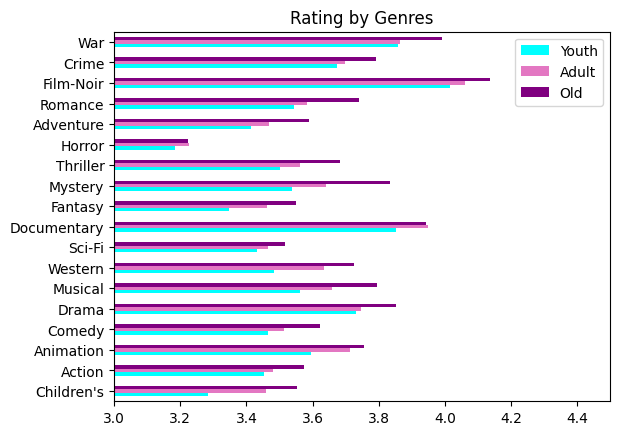

In [21]:
df_2.plot.barh(y=[('Youth', 'mean'), ('Adult', 'mean'), ('Old', 'mean')], color=['cyan', 'tab:pink', 'purple'])
plt.title('Rating by Genres')
plt.xlim(3, 4.5)
plt.legend(['Youth', 'Adult', 'Old'])


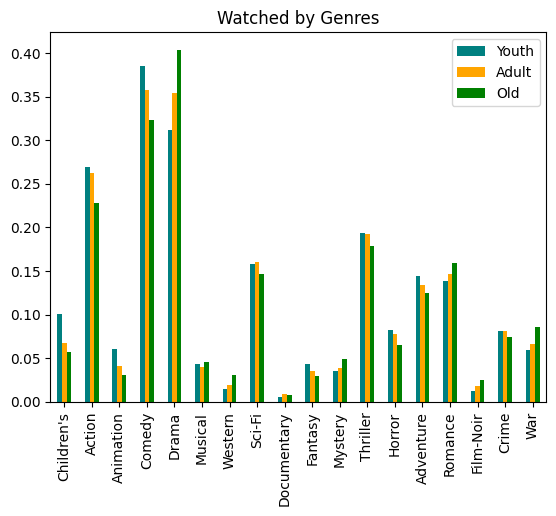

In [22]:
df_2.plot.bar(y=[('Youth', 'portion'), ('Adult', 'portion'), ('Old', 'portion')], color=[(0, 128/255, 128/255), 'orange', 'green'])
plt.title('Watched by Genres')
plt.legend(['Youth', 'Adult', 'Old'])

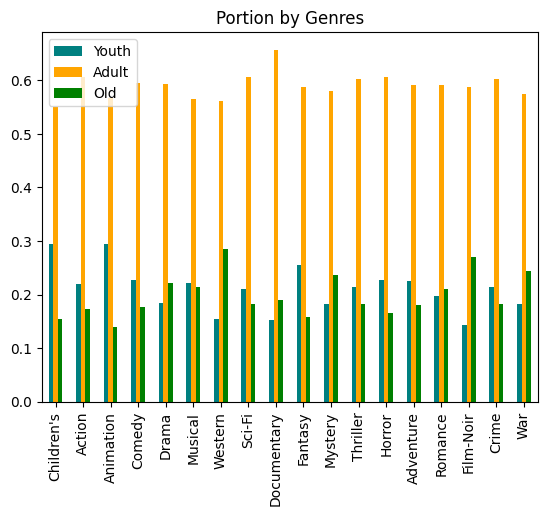

In [23]:
df_2.plot.bar(y=[('Youth', 'portion_2'), ('Adult', 'portion_2'), ('Old', 'portion_2')], color=[(0, 128/255, 128/255), 'orange', 'green'])
plt.title('Portion by Genres')
plt.legend(['Youth', 'Adult', 'Old'])

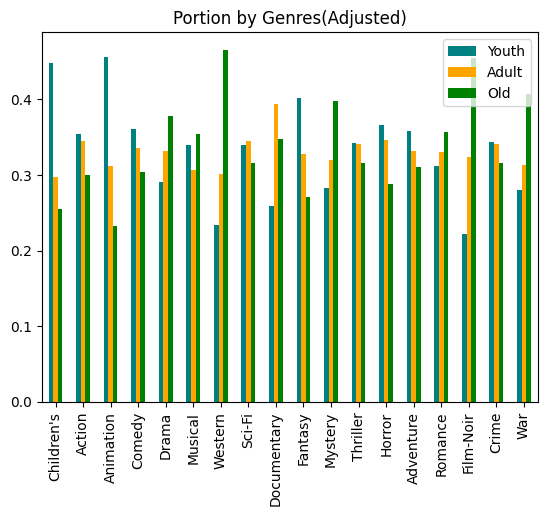

In [24]:
df_2.plot.bar(y=[('Youth', 'portion_3'), ('Adult', 'portion_3'), ('Old', 'portion_3')], color=[(0, 128/255, 128/255), 'orange', 'green'])
plt.title('Portion by Genres(Adjusted)')
plt.legend(['Youth', 'Adult', 'Old'])

#### 二、用户评分预测（40分）

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
import lightgbm as lgb

1. 特征工程：创建用户和电影的特征，包括性别、年龄、职业、电影类型（等），并进行适当的One-Hot编码处理，并进行适度的降维。（10分）<br>
--性别、年龄、职业、电影类型四个特征的提取以及One-Hot编码处理（8分）<br>
--使用累计方差PCA等方式降维（2分）

In [26]:
merged_data = pd.merge(ratings, users, on='user_id', how='left')
merged_data = pd.merge(merged_data, movies, on='movie_id', how='left')
merged_data = pd.merge(merged_data, movies_info, on='movie_id', how='left')
merged_data['year']=merged_data['release_time']

In [27]:
merged_data.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'gender', 'zipcode',
       'age_desc', 'occ_desc', 'title', 'genres_x', 'Children's', 'Action',
       'Animation', 'Comedy', 'Drama', 'Musical', 'Western', 'Sci-Fi',
       'Documentary', 'Fantasy', 'Mystery', 'Thriller', 'Horror', 'Adventure',
       'Romance', 'Film-Noir', 'Crime', 'War', 'name', 'genres_y',
       'release_time', 'intro', 'directors', 'stars', 'year'],
      dtype='object')

In [28]:
features = merged_data[['gender', 'age_desc', 'occ_desc', 'Fantasy', 'Crime',
       'Romance', 'Musical', 'Action', 'Mystery', 'Animation', 'Thriller',
       'Comedy', 'Adventure', 'Documentary', 'Sci-Fi', 'Drama', 'Western',
       'Film-Noir', "Children's", 'Horror', 'War']]
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), ['gender', 'age_desc', 'occ_desc'])],
    remainder='passthrough')
one_hot_features = column_transformer.fit_transform(features)
print(one_hot_features.shape)
pca=PCA(n_components=0.95)
reduced_features=pca.fit_transform(one_hot_features)

(1000209, 48)


In [29]:
svd = TruncatedSVD(n_components=20)
reduced_features_svd = svd.fit_transform(one_hot_features)

2. 模型选择与训练：选择合适的机器学习模型或统计模型进行训练。（10分）<br>
--将数据集分成训练集与测试集（8:2）（2分）<br>
--使用合适的机器学习模型进行训练（8分）

In [31]:
target=merged_data['rating']
X_train, X_test, y_train, y_test = train_test_split(reduced_features, target, test_size=0.2, random_state=42)
model = lgb.LGBMClassifier(verbose=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [32]:
X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(reduced_features_svd, target, test_size=0.2, random_state=42)
model = lgb.LGBMClassifier(verbose=-1)
model.fit(X_train_svd, y_train_svd)
y_pred_svd = model.predict(X_test_svd)

3. 预测与评估：使用测试集对模型进行预测，并使用MSE等指标评估预测的准确性。（10分）<br>
--使用numpy写一个高效的MSE函数（而不是for循环）（2分）<br>
--在测试集上进行预测与评估，要求达到MSE<2的标准（8分）


In [33]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

In [34]:
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 1.3952769918317154


In [35]:
mse_svd = mean_squared_error(y_test_svd, y_pred_svd)
print("MSE_SVD:", mse_svd)

MSE_SVD: 1.399966007138501


4. “高等级分数”10分：<br>
MSE<1——得10分<br>
使用了<br>
①除电影简介、海报信息以外的特征：一种+2；电影简介、海报信息：一种+4<br>
②特征工程方法（降维、聚类等）：一种+4<br>
③探索更多模型：一种+4<br>
加入电影信息（如国家、年份、简介、评分、海报信息等）之后如果获得特别好的效果(MSE<0.8)，可以另外再加5分（真正的附加分）。


（1）将上述基础预测步骤中的PCA降维更换为截断SVD降维：见步骤1-3

（2）添加movie_id, year, country, movie_intro作为特征加入特征工程，并结合截断SVD做降维

In [36]:
merged_data = merged_data.dropna(subset=['intro'])
movie_intro=merged_data['intro'].tolist()
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_intro)
lsa_model = TruncatedSVD(n_components=200)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
lsa_matrix.shape

(981855, 200)

In [37]:
import re
def extract_info(date_str):
    year = re.findall(r'\b\d{4}\b', date_str)[0]  # 提取四位数字作为年份
    country_match = re.search(r'\((.*?)\)', date_str)  # 在括号中提取国家信息
    country = country_match.group(1) if country_match else None
    return year, country
merged_data[['Year', 'Country']] = merged_data['year'].apply(lambda x: pd.Series(extract_info(x)))
merged_data['Year'] = merged_data['Year'].astype(int)

In [38]:
features = merged_data[['gender', 'Year','Country','age_desc', 'occ_desc', 'movie_id','Fantasy', 'Crime',
       'Romance', 'Musical', 'Action', 'Mystery', 'Animation', 'Thriller',
       'Comedy', 'Adventure', 'Documentary', 'Sci-Fi', 'Drama', 'Western',
       'Film-Noir', "Children's", 'Horror', 'War']]
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), ['gender', 'age_desc', 'occ_desc','Country'])],
    remainder='passthrough')
one_hot_features = column_transformer.fit_transform(features)
one_hot_features.shape

(981855, 94)

In [39]:
lsa_df=pd.DataFrame(lsa_matrix)
feature_df=pd.DataFrame(one_hot_features.toarray())
combined_features = pd.concat([feature_df, lsa_df], axis=1)
svd = TruncatedSVD(n_components=100)
reduced_features_svd = svd.fit_transform(combined_features)

（3）除了LightGBM之外，使用LogisticRegression, Linear Discriminant Analysis, XGBoost模型来预测

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [41]:
target=merged_data['rating']
X_train, X_test, y_train, y_test = train_test_split(reduced_features_svd, target, test_size=0.2, random_state=42)
y_train=y_train-1
y_test=y_test-1

In [42]:
clfs={
    'Logistic Regression': LogisticRegression(),
    'LightGBM': lgb.LGBMClassifier(verbose=-1),
    'XGBoost': XGBClassifier(),
    #'SVM': SVC(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    #'Random Forest': RandomForestClassifier(),
}

In [43]:
for clf_name,clf in clfs.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(clf_name," MSE:",mse)

Logistic Regression  MSE: 1.4231072816250872
LightGBM  MSE: 1.1951611999735194
XGBoost  MSE: 1.192329824668612
Linear Discriminant Analysis  MSE: 1.4192472411914183


#### 三、海报按内容聚类（30分）


1. 图像特征提取：从电影海报中提取颜色直方图和灰度直方图等特征。（5分）<br>
--颜色直方图（2分）<br>
--灰度直方图（2分）<br>
--向量拼接（1分）

In [44]:
import os
import cv2
from PIL import Image
import torch
from img2vec_pytorch import Img2Vec
from tqdm import tqdm
from sklearn.cluster import KMeans

In [45]:
import torchvision
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [46]:
def extract_color_histogram(image):
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def extract_grayscale_histogram(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

folder_path = "./poster"
features = []
img2vec_model = Img2Vec()

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        color_hist = extract_color_histogram(image)
        gray_image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        gray_hist = extract_grayscale_histogram(gray_image)
        image0 = Image.open(image_path)
        if image0.mode != 'RGB':
            image0 = image0.convert('RGB')
        vector = img2vec_model.get_vec(image0)
        feature_vector = np.concatenate((color_hist, gray_hist, vector))
        features.append([filename.split('.')[0], feature_vector])
       

columns = ['movie_id', 'features']
df = pd.DataFrame(features, columns=columns)

print("DataFrame with Movie ID and Features:")
print(df.head())

100%|██████████| 2938/2938 [02:01<00:00, 24.09it/s]

DataFrame with Movie ID and Features:
  movie_id                                           features
0        1  [0.17029727, 0.23140292, 0.21716808, 0.0751668...
1       10  [0.9702742, 0.0173933, 0.00018752884, 0.000140...
2      100  [0.9752874, 0.025105717, 0.005648786, 0.004219...
3     1003  [0.9776281, 0.017353397, 0.0075379815, 0.00336...
4     1004  [0.948668, 0.20798023, 0.0, 0.0, 0.0, 0.0, 0.0...


2. 降维：使用PCA等方法对特征进行降维处理。（5分）<br>
--使用累计方差PCA（3分）<br>
--同时还进行了其它探索（再得2分）

In [47]:
X = np.array(df['features'].tolist())
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X)
pca_features_list = X_pca.tolist()
df_result = pd.DataFrame({'movie_id': df['movie_id'], 'pca_features': pca_features_list})

print("DataFrame with Movie ID and PCA Features:")
print(df_result.head())

DataFrame with Movie ID and PCA Features:
  movie_id                                       pca_features
0        1  [0.39958012104034424, 6.453545570373535, -1.67...
1       10  [-3.4519400596618652, -1.992896318435669, -3.3...
2      100  [-1.1995089054107666, -7.333141803741455, 4.98...
3     1003  [-1.0824620723724365, -7.392695903778076, -0.1...
4     1004  [-0.4197857081890106, -6.109785079956055, -4.9...


In [48]:
n_components = 50  
svd = TruncatedSVD(n_components=n_components)
X_svd = svd.fit_transform(X)
svd_features_list = X_svd.tolist()
df_result_svd = pd.DataFrame({'movie_id': df['movie_id'], 'svd_features': svd_features_list})

print("DataFrame with Movie ID and Truncated SVD Features:")
print(df_result_svd.head())

DataFrame with Movie ID and Truncated SVD Features:
  movie_id                                       svd_features
0        1  [24.60973358154297, 1.458640456199646, 6.81990...
1       10  [23.475494384765625, -3.112093210220337, -2.01...
2      100  [21.9930419921875, -0.9966939091682434, -7.354...
3     1003  [21.576322555541992, -1.0070216655731201, -7.4...
4     1004  [22.84920310974121, 0.025550425052642822, -6.0...


3. 无监督聚类分析：应用k-means等算法对电影海报进行无监督聚类（5分）

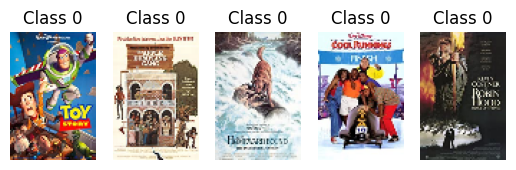

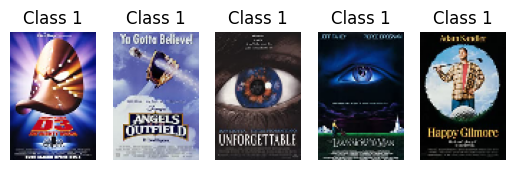

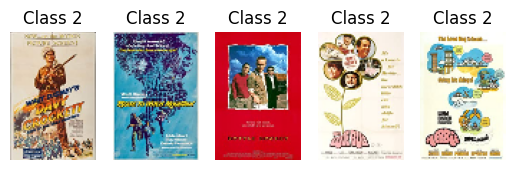

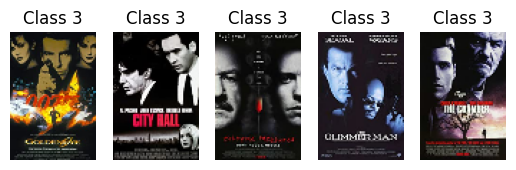

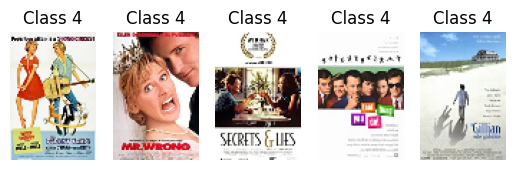

In [49]:
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters)

kmeans.fit(X)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
df['cluster_label'] = labels

for i in range(n_clusters):
    representative_images_indices = [df[df['cluster_label'] == i].index[j] for j in range(min(5, len(df[df['cluster_label'] == i])))]
    for j, index in enumerate(representative_images_indices):
        representative_image_path = os.path.join(folder_path, os.listdir(folder_path)[index])
        representative_image = cv2.imread(representative_image_path)
        representative_image = cv2.resize(representative_image, (60, 90))
        plt.subplot(1, 5, j+1)
        plt.imshow(cv2.cvtColor(representative_image, cv2.COLOR_BGR2RGB))
        plt.title("Class {}".format(i))
        plt.axis("off")
    plt.show()

4. 有监督聚类分析：应用分类算法对电影海报进行内容聚类。（5分）<br>
--划分数据集（1分）<br>
--选择合适的分类算法进行训练与测试（2分）<br>
--分类结果准确度>0.2（2分）

In [50]:
movies_df = pd.read_csv("./movies.csv")
genres = movies_df['genres']
genre_dict = {}
for genre_string in genres:
    genre_list = genre_string.split("|")
    for genre in genre_list:
        if genre not in genre_dict:
            genre_dict[genre] = len(genre_dict)
print("Genre Dictionary:")
print(genre_dict)
genre_vectors = []
for genre_string in genres:
    genre_list = genre_string.split("|")
    genre_vector = [0] * len(genre_dict)
    for genre in genre_list:
        genre_vector[genre_dict[genre]] = 1
    genre_vectors.append(genre_vector)
genre_lists = [list(genre_vector) for genre_vector in genre_vectors]
movies_df['genre_vector'] = genre_lists
print("\nMovies DataFrame with Genre Vector:")
print(movies_df.head())

Genre Dictionary:
{'Animation': 0, "Children's": 1, 'Comedy': 2, 'Adventure': 3, 'Fantasy': 4, 'Romance': 5, 'Drama': 6, 'Action': 7, 'Crime': 8, 'Thriller': 9, 'Horror': 10, 'Sci-Fi': 11, 'Documentary': 12, 'War': 13, 'Musical': 14, 'Mystery': 15, 'Film-Noir': 16, 'Western': 17}

Movies DataFrame with Genre Vector:
   Unnamed: 0  movie_id                               title  \
0           0         1                    Toy Story (1995)   
1           1         2                      Jumanji (1995)   
2           2         3             Grumpier Old Men (1995)   
3           3         4            Waiting to Exhale (1995)   
4           4         5  Father of the Bride Part II (1995)   

                         genres  \
0   Animation|Children's|Comedy   
1  Adventure|Children's|Fantasy   
2                Comedy|Romance   
3                  Comedy|Drama   
4                        Comedy   

                                        genre_vector  
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [51]:
movies_df['movie_id'] = movies_df['movie_id'].astype(int)
df['movie_id'] = df['movie_id'].astype(int)
df_result['movie_id'] = df_result['movie_id'].astype(int)
df_result_svd['movie_id'] = df_result_svd['movie_id'].astype(int)
merged_df = pd.merge(movies_df, df, on='movie_id', how='inner')
merged_df = pd.merge(merged_df, df_result, on='movie_id', how='inner')
merged_df = pd.merge(merged_df, df_result_svd, on='movie_id', how='inner')
print("Merged DataFrame:")
print(merged_df.head())
print(merged_df.shape)

Merged DataFrame:
   Unnamed: 0  movie_id                               title  \
0           0         1                    Toy Story (1995)   
1           1         2                      Jumanji (1995)   
2           2         3             Grumpier Old Men (1995)   
3           3         4            Waiting to Exhale (1995)   
4           4         5  Father of the Bride Part II (1995)   

                         genres  \
0   Animation|Children's|Comedy   
1  Adventure|Children's|Fantasy   
2                Comedy|Romance   
3                  Comedy|Drama   
4                        Comedy   

                                        genre_vector  \
0  [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                            features  c

In [52]:
X = np.array(merged_df['pca_features'].tolist())
y = np.array(merged_df['genre_vector'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2350, 177), (2350, 18), (588, 177), (588, 18))

In [54]:
X_svd = np.array(merged_df['svd_features'].tolist())
y_svd = np.array(merged_df['genre_vector'].tolist())

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y_svd, test_size=0.2, random_state=42)

In [55]:
classifiers = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
}

In [56]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = BinaryRelevance(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: XGBoost
Accuracy: 0.10884353741496598

Classifier: Logistic Regression
Accuracy: 0.12755102040816327

Classifier: Random Forest
Accuracy: 0.03571428571428571

Classifier: SVM
Accuracy: 0.1360544217687075

Classifier: MLP
Accuracy: 0.14285714285714285

Classifier: KNN
Accuracy: 0.1054421768707483

Classifier: Naive Bayes
Accuracy: 0.07993197278911565

Classifier: Decision Tree
Accuracy: 0.04591836734693878

Classifier: Linear Discriminant Analysis
Accuracy: 0.13435374149659865


In [57]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier =  BinaryRelevance(classifier=clf)
    classifier.fit(X_train_svd, y_train_svd)
    y_pred_svd = classifier.predict(X_test_svd)
    accuracy = accuracy_score(y_test_svd, y_pred_svd)
    print("Accuracy:", accuracy)


Classifier: XGBoost
Accuracy: 0.1292517006802721

Classifier: Logistic Regression
Accuracy: 0.14625850340136054

Classifier: Random Forest
Accuracy: 0.07312925170068027

Classifier: SVM
Accuracy: 0.11224489795918367

Classifier: MLP
Accuracy: 0.11904761904761904

Classifier: KNN
Accuracy: 0.1377551020408163

Classifier: Naive Bayes
Accuracy: 0.14965986394557823

Classifier: Decision Tree
Accuracy: 0.0391156462585034

Classifier: Linear Discriminant Analysis
Accuracy: 0.15136054421768708


In [58]:
classifiers = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
}

In [59]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = LabelPowerset(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: XGBoost


Accuracy: 0.17006802721088435

Classifier: Logistic Regression
Accuracy: 0.1445578231292517

Classifier: Random Forest
Accuracy: 0.19727891156462585

Classifier: SVM
Accuracy: 0.23469387755102042

Classifier: MLP
Accuracy: 0.1649659863945578

Classifier: KNN
Accuracy: 0.17517006802721088

Classifier: Naive Bayes
Accuracy: 0.14795918367346939

Classifier: Decision Tree
Accuracy: 0.08503401360544217

Classifier: Linear Discriminant Analysis
Accuracy: 0.1921768707482993


In [60]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = LabelPowerset(classifier=clf)
    classifier.fit(X_train_svd, y_train_svd)
    y_pred_svd = classifier.predict(X_test_svd)
    accuracy = accuracy_score(y_test_svd, y_pred_svd)
    print("Accuracy:", accuracy)


Classifier: XGBoost
Accuracy: 0.20238095238095238

Classifier: Logistic Regression
Accuracy: 0.1564625850340136

Classifier: Random Forest
Accuracy: 0.20408163265306123

Classifier: SVM
Accuracy: 0.22959183673469388

Classifier: MLP
Accuracy: 0.13945578231292516

Classifier: KNN
Accuracy: 0.18197278911564627

Classifier: Naive Bayes
Accuracy: 0.1717687074829932

Classifier: Decision Tree
Accuracy: 0.07482993197278912

Classifier: Linear Discriminant Analysis
Accuracy: 0.19727891156462585


In [61]:
classifiers = {
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
}

In [62]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = ClassifierChain(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: XGBoost
Accuracy: 0.1683673469387755

Classifier: Logistic Regression
Accuracy: 0.1836734693877551

Classifier: Random Forest
Accuracy: 0.06292517006802721

Classifier: SVM
Accuracy: 0.14625850340136054

Classifier: MLP
Accuracy: 0.1683673469387755

Classifier: KNN
Accuracy: 0.10714285714285714

Classifier: Naive Bayes
Accuracy: 0.0

Classifier: Decision Tree
Accuracy: 0.05782312925170068

Classifier: Linear Discriminant Analysis
Accuracy: 0.20068027210884354


In [63]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = ClassifierChain(classifier=clf)
    classifier.fit(X_train_svd, y_train_svd)
    y_pred_svd = classifier.predict(X_test_svd)
    accuracy = accuracy_score(y_test_svd, y_pred_svd)
    print("Accuracy:", accuracy)


Classifier: XGBoost
Accuracy: 0.17006802721088435

Classifier: Logistic Regression
Accuracy: 0.2227891156462585

Classifier: Random Forest
Accuracy: 0.15816326530612246

Classifier: SVM
Accuracy: 0.12585034013605442

Classifier: MLP
Accuracy: 0.1377551020408163

Classifier: KNN
Accuracy: 0.13945578231292516

Classifier: Naive Bayes
Accuracy: 0.0

Classifier: Decision Tree
Accuracy: 0.08163265306122448

Classifier: Linear Discriminant Analysis
Accuracy: 0.22448979591836735


5. “高等级分数” 10分：<br>
(1)利用电影内容及评分信息，包括用户偏好信息，优化海报有监督聚类。<br>
分类结果准确度：>0.3（得5分）>0.4（得10分）<br>
(2)或者利用海报内容与无监督聚类结果，优化用户对电影的评分预测。<br>
--合理的海报聚类结果利用方式（5分）<br>
--MSE<0.9（5分）或者 如果你有对于将无监督聚类结果信息加入到模型中表现不佳的合理解释（5分）

以下尝试没能使得准确度>0.3

（1）directors, stars, posters, year, country, intro全部加入特征工程

In [64]:
df['movie_id'] = df['movie_id'].astype(int)
df=df.sort_values(by='movie_id')
features_array = np.array(df['features'].tolist())
model = TruncatedSVD(n_components=200)
img_fea = model.fit_transform(features_array)
img0=pd.DataFrame(img_fea)

In [65]:
mdf=pd.merge(movies,movies_info,on='movie_id',how='left')
mdf=mdf[mdf['movie_id'].isin(df['movie_id'])]
mdf=mdf[['movie_id', 'title', 'genres_x', 'name', 'release_time','intro', 'directors', 'stars']]
mdf[['Year', 'Country']] = mdf['release_time'].apply(lambda x: pd.Series(extract_info(x)))
mdf['Year'] = mdf['Year'].astype(int)
features = mdf[[ 'Year','Country']]
column_transformer = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(), ['Country'])],
    remainder='passthrough')
one_hot_features = column_transformer.fit_transform(features)
one_hot=pd.DataFrame(one_hot_features.toarray())

In [66]:
m_intro=mdf['intro'].tolist()
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(m_intro)
tfidf_matrix.shape
lsa_model = TruncatedSVD(n_components=200)
lsa_matrix = lsa_model.fit_transform(tfidf_matrix)
lsa0=pd.DataFrame(lsa_matrix)

In [67]:
directors = movies_info['directors']
director_dict = {}
for director_string in directors:
    if not pd.isna(director_string):
        director_list = director_string.split("|")
        for director in director_list:
            if director not in director_dict:
                director_dict[director] = len(director_dict)
director_vectors = []
for director_string in directors:
    if pd.isna(director_string):
        director_vector = [0] * len(director_dict)
    else:
        director_list = director_string.split("|")
        director_vector = [0] * len(director_dict)
        for director in director_list:
            director_vector[director_dict[director]] = 1
    director_vectors.append(director_vector)
director_lists = [list(director_vector) for director_vector in director_vectors]
movies_info['director_vector'] = director_lists
direc_df = pd.merge(mdf[['movie_id']], movies_info[['movie_id','director_vector']], on='movie_id', how='left')
direc_df=np.array(direc_df['director_vector'].tolist())
model = TruncatedSVD(n_components=50)
direc_fea = model.fit_transform(direc_df)
direc0=pd.DataFrame(direc_fea)

In [68]:
stars = movies_info['stars']
star_dict = {}
for star_string in stars:
    if not pd.isna(star_string):
        star_list = star_string.split("|")
        for star in star_list:
            if star not in star_dict:
                star_dict[star] = len(star_dict)
star_vectors = []
for star_string in stars:
    if pd.isna(star_string):
        star_vector = [0] * len(star_dict)
    else:
        star_list = star_string.split("|")
        star_vector = [0] * len(star_dict)
        for star in star_list:
            star_vector[star_dict[star]] = 1
    star_vectors.append(star_vector)
star_lists = [list(star_vector) for star_vector in star_vectors]
movies_info['star_vector'] = star_lists
star_df = pd.merge(mdf[['movie_id']], movies_info[['movie_id', 'star_vector']], on='movie_id', how='left')
star_df=np.array(star_df['star_vector'].tolist())
model = TruncatedSVD(n_components=50)
star_fea = model.fit_transform(star_df)
star0=pd.DataFrame(star_fea)

In [69]:
new_feature=pd.concat([img0,one_hot,lsa0,direc0,star0],axis=1)
model = TruncatedSVD(n_components=500)
new_feature = model.fit_transform(new_feature)
new_feature.shape

(2938, 500)

In [70]:
X = np.array(new_feature)
y = np.array(merged_df['genre_vector'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [72]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = BinaryRelevance(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.14625850340136054

Classifier: Linear Discriminant Analysis
Accuracy: 0.18197278911564627

Classifier: Naive Bayes
Accuracy: 0.017006802721088437

Classifier: Decision Tree
Accuracy: 0.05102040816326531

Classifier: Random Forest
Accuracy: 0.03741496598639456

Classifier: SVM
Accuracy: 0.0

Classifier: MLP
Accuracy: 0.12414965986394558

Classifier: KNN
Accuracy: 0.1445578231292517

Classifier: XGBoost
Accuracy: 0.15306122448979592


In [73]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [74]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = LabelPowerset(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.23129251700680273

Classifier: Linear Discriminant Analysis
Accuracy: 0.21768707482993196

Classifier: Naive Bayes
Accuracy: 0.09863945578231292

Classifier: Decision Tree
Accuracy: 0.08333333333333333

Classifier: Random Forest
Accuracy: 0.2227891156462585

Classifier: SVM
Accuracy: 0.18537414965986396

Classifier: MLP
Accuracy: 0.19727891156462585

Classifier: KNN
Accuracy: 0.18877551020408162

Classifier: XGBoost
Accuracy: 0.18197278911564627


In [75]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [76]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = ClassifierChain(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.17517006802721088

Classifier: Linear Discriminant Analysis
Accuracy: 0.2108843537414966

Classifier: Naive Bayes
Accuracy: 0.0017006802721088435

Classifier: Decision Tree
Accuracy: 0.06972789115646258

Classifier: Random Forest
Accuracy: 0.05952380952380952

Classifier: SVM
Accuracy: 0.0

Classifier: MLP
Accuracy: 0.20238095238095238

Classifier: KNN
Accuracy: 0.14625850340136054

Classifier: XGBoost
Accuracy: 0.1717687074829932


（2）将posters, intro, title加入特征工程

In [77]:
m_title=mdf['title'].tolist()
m_title = [re.sub(r'\([^()]*\)', '', s) for s in m_title]
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix0 = tfidf_vectorizer.fit_transform(m_title)
lsa_model = TruncatedSVD(n_components=100)
lsa_matrix0 = lsa_model.fit_transform(tfidf_matrix0)
lsa00=pd.DataFrame(lsa_matrix0)

In [78]:
new_feature=pd.concat([img0,lsa0,lsa00],axis=1)
new_feature.shape

(2938, 500)

In [79]:
X = np.array(new_feature)
y = np.array(merged_df['genre_vector'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [81]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = BinaryRelevance(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.14795918367346939

Classifier: Linear Discriminant Analysis
Accuracy: 0.17346938775510204

Classifier: Naive Bayes
Accuracy: 0.022108843537414966

Classifier: Decision Tree
Accuracy: 0.04421768707482993

Classifier: Random Forest
Accuracy: 0.02891156462585034

Classifier: SVM
Accuracy: 0.1326530612244898

Classifier: MLP
Accuracy: 0.17857142857142858

Classifier: KNN
Accuracy: 0.11734693877551021

Classifier: XGBoost
Accuracy: 0.13435374149659865


In [82]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [83]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = LabelPowerset(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.1564625850340136

Classifier: Linear Discriminant Analysis
Accuracy: 0.22789115646258504

Classifier: Naive Bayes
Accuracy: 0.07482993197278912

Classifier: Decision Tree
Accuracy: 0.08673469387755102

Classifier: Random Forest
Accuracy: 0.21598639455782312

Classifier: SVM
Accuracy: 0.23299319727891157

Classifier: MLP
Accuracy: 0.17346938775510204

Classifier: KNN
Accuracy: 0.18197278911564627

Classifier: XGBoost
Accuracy: 0.20238095238095238


In [84]:
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'MLP': MLPClassifier(),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(),
}

In [85]:
for clf_name, clf in classifiers.items():
    print(f"\nClassifier: {clf_name}")
    classifier = ClassifierChain(classifier=clf)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)


Classifier: Logistic Regression
Accuracy: 0.1989795918367347

Classifier: Linear Discriminant Analysis
Accuracy: 0.21768707482993196

Classifier: Naive Bayes
Accuracy: 0.015306122448979591

Classifier: Decision Tree
Accuracy: 0.07482993197278912

Classifier: Random Forest
Accuracy: 0.04591836734693878

Classifier: SVM
Accuracy: 0.1445578231292517

Classifier: MLP
Accuracy: 0.1989795918367347

Classifier: KNN
Accuracy: 0.11734693877551021

Classifier: XGBoost
Accuracy: 0.20918367346938777
